# 01 — Airbnb Price Model

This notebook kickstarts the Airbnb price prediction project. It includes data loading, exploratory data analysis, preprocessing, model training, and evaluation sections.

## Objectives

- Load and inspect raw data
- Perform exploratory data analysis (EDA)
- Preprocess features and split dataset
- Train baseline models and evaluate performance

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn helpers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("Environment is ready")

Environment is ready


In [5]:
import os

RAW_DIR = "../data/raw"

def load_listings(filename: str, snapshot: str) -> pd.DataFrame:
    path = os.path.join(RAW_DIR, filename)
    df = pd.read_csv(path, low_memory=False)
    df["snapshot"] = snapshot
    return df

ams_q1 = load_listings("amsterdam-2025q1-listings.csv.gz", "amsterdam_q1_2025")

ams_q3 = load_listings("amsterdam-2025q3-listings.csv.gz", "amsterdam_q3_2025")

bru_q3 = load_listings("brussels-2025q3-listings.csv.gz", "brussels_q3_2025")

print("Row counts:")
print("Amsterdam Q1:", len(ams_q1))
print("Amsterdam Q3:", len(ams_q3))
print("Brussels Q3 :", len(bru_q3))

print("\nKey columns check:")
print([c for c in ["price", "amenities", "room_type", "accommodates", "bedrooms"] if c in ams_q1.columns])


Row counts:
Amsterdam Q1: 10075
Amsterdam Q3: 10480
Brussels Q3 : 6131

Key columns check:
['price', 'amenities', 'room_type', 'accommodates', 'bedrooms']


---

### Step 1. Cleaning the target (price) + basic filtering

In [6]:
def clean_price(series: pd.Series) -> pd.Series:
    # Handles "$1,234.00", "€123", "123" etc.
    s = series.astype(str).str.replace(r"[^\d\.]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

for df in [ams_q1, ams_q3, bru_q3]:
    df["price_clean"] = clean_price(df["price"])

print("Missing price_clean (share):")
print("Amsterdam Q1:", ams_q1["price_clean"].isna().mean())
print("Amsterdam Q3:", ams_q3["price_clean"].isna().mean())
print("Brussels Q3 :", bru_q3["price_clean"].isna().mean())

print("\nAmsterdam Q1 price summary:")
print(ams_q1["price_clean"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

Missing price_clean (share):
Amsterdam Q1: 0.4133002481389578
Amsterdam Q3: 0.4395038167938931
Brussels Q3 : 0.1738704942097537

Amsterdam Q1 price summary:
count     5911.000000
mean       265.115716
std        422.193489
min         10.000000
1%          57.000000
5%          84.000000
50%        209.000000
95%        539.000000
99%        953.600000
max      14404.000000
Name: price_clean, dtype: float64


In [7]:
def basic_filters(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[df["price_clean"].notna()]
    df = df[df["price_clean"] > 0]
    # winsorize-ish: remove extreme outliers
    p01, p99 = df["price_clean"].quantile([0.01, 0.99])
    df = df[(df["price_clean"] >= p01) & (df["price_clean"] <= p99)]
    return df

ams_q1_f = basic_filters(ams_q1)
ams_q3_f = basic_filters(ams_q3)
bru_q3_f = basic_filters(bru_q3)

print("Rows after filters:")
print("Amsterdam Q1:", len(ams_q1_f))
print("Amsterdam Q3:", len(ams_q3_f))
print("Brussels Q3 :", len(bru_q3_f))


Rows after filters:
Amsterdam Q1: 5794
Amsterdam Q3: 5760
Brussels Q3 : 4963


### 2. Variable selection & feature engineering plan

Target: nightly listing price (price_clean)

Core numeric features: accommodates, bedrooms, beds, minimum_nights, availability_365, number_of_reviews, reviews_per_month, host_listings_count (when available)

Categorical features: room_type, neighbourhood (handled via one-hot with control for high cardinality)

Amenities: convert amenities text into (i) count of amenities and (ii) top-N amenity indicators

Missing values: median for numeric, “Unknown” for categorical

Same pipeline applied to all datasets for validity testing.

#### 3. Amenities feature engineering (simple + effective)

In [8]:
import re

def parse_amenities(x):
    if pd.isna(x):
        return []
    return re.findall(r'"([^"]+)"', str(x))

for df in [ams_q1_f, ams_q3_f, bru_q3_f]:
    df["amenities_list"] = df["amenities"].apply(parse_amenities)
    df["n_amenities"] = df["amenities_list"].apply(len)

# Build a top-50 amenity vocabulary from training city/time only (important!)
from collections import Counter
amenity_counts = Counter(a for row in ams_q1_f["amenities_list"] for a in row)
TOP_N = 50
top_amenities = [a for a, _ in amenity_counts.most_common(TOP_N)]

print("Example top amenities:", top_amenities[:10])


Example top amenities: ['Smoke alarm', 'Wifi', 'Hot water', 'Kitchen', 'Essentials', 'Dishes and silverware', 'Bed linens', 'Hair dryer', 'Refrigerator', 'Hangers']


In [9]:
# Converting amenities to column dummies

def add_amenity_dummies(df, vocab):
    df = df.copy()
    aset = df["amenities_list"].apply(set)
    for a in vocab:
        col = f"amen_{re.sub(r'[^0-9a-zA-Z]+','_', a).lower()}"[:60]
        df[col] = aset.apply(lambda s: int(a in s))
    return df

ams_q1_fe = add_amenity_dummies(ams_q1_f, top_amenities)
ams_q3_fe = add_amenity_dummies(ams_q3_f, top_amenities)
bru_q3_fe = add_amenity_dummies(bru_q3_f, top_amenities)

print("Added amenity dummy columns:", sum(c.startswith("amen_") for c in ams_q1_fe.columns))


Added amenity dummy columns: 50


In [10]:
# quick hash for amenities dummies so the names are unique but short.
import hashlib

def add_amenity_dummies(df, vocab):
    df = df.copy()
    aset = df["amenities_list"].apply(set)

    for a in vocab:  
        col = f"amen_{re.sub(r'[^0-9a-zA-Z]+','_', a).lower()}"[:60]
        df[col] = aset.apply(lambda s: int(a in s))

    return df

# keeping the vocab for later use, for extra GitHub polish
import json

os.makedirs("../reports", exist_ok=True)
with open("../reports/top_amenities_amsterdam_q1.json", "w", encoding="utf-8") as f:
    json.dump(top_amenities, f, ensure_ascii=False, indent=2)


In [11]:
# Sanity check
# 1) Make sure amenities_list is not empty for most rows
print("Share with 0 amenities (Amsterdam Q1):", (ams_q1_fe["n_amenities"] == 0).mean())

# 2) Amenity prevalence looks reasonable (not all 0/1)
amen_cols = [c for c in ams_q1_fe.columns if c.startswith("amen_")]
print("Amenity dummy mean range (Amsterdam Q1):",
      ams_q1_fe[amen_cols].mean().min(),
      ams_q1_fe[amen_cols].mean().max())

# 3) Column consistency across datasets
print("Amenity cols equal across datasets:",
      set([c for c in ams_q1_fe.columns if c.startswith("amen_")]) ==
      set([c for c in ams_q3_fe.columns if c.startswith("amen_")]) ==
      set([c for c in bru_q3_fe.columns if c.startswith("amen_")]))

print("Data preparation complete.")

Share with 0 amenities (Amsterdam Q1): 0.0008629616845012082
Amenity dummy mean range (Amsterdam Q1): 0.2285122540559199 0.913531239212979
Amenity cols equal across datasets: True
Data preparation complete.


## Feature Engineering & Data Preparation Summary

Before building predictive models, we constructed a consistent and interpretable feature set based on Inside Airbnb listings data.

**Target variable**
- Nightly listing price (`price_clean`), parsed from the raw `price` field.
- Listings with missing or zero prices were excluded, as price is the prediction target.
- Extreme outliers were removed using a 1–99% quantile filter to improve model stability.

**Core numeric features**
- Listing capacity and size: `accommodates`, `bedrooms`, `beds`
- Booking constraints and availability: `minimum_nights`, `availability_365`
- Popularity signals: `number_of_reviews`, `reviews_per_month`
- Host scale: `host_listings_count`, `host_total_listings_count`
- Amenity richness: `n_amenities` (total number of amenities)

**Categorical features**
- `room_type`, encoded via one-hot encoding.

**Amenities**
- Amenities were parsed from the raw text field into lists.
- A vocabulary of the top 50 most frequent amenities was constructed using the training dataset only (Amsterdam Q1 2025) to avoid information leakage.
- These amenities were converted into binary indicator variables and applied consistently across all datasets.

**Missing values**
- Numeric features: imputed using the median.
- Categorical features: imputed using the most frequent category.

**Reproducibility & validity**
- The same preprocessing and feature engineering pipeline is applied to:
  - the training dataset (Amsterdam Q1 2025),
  - a later snapshot from the same city (Amsterdam Q3 2025),
  - and a different city in the same region (Brussels Q3 2025).
- This ensures that differences in model performance reflect temporal and spatial variation rather than changes in data preparation.

With this standardized feature set, we proceed to build and compare multiple predictive models.

---

## Target Transformation: Log Price

Airbnb nightly prices exhibit a strongly right-skewed distribution, with a small number of very expensive listings and a long right tail. Modeling prices in levels would place disproportionate weight on these extreme observations and can lead to unstable predictions, especially for tree-based and boosting models.

To address this, all models in this analysis are trained on the logarithm of the nightly price:

\[y = \log(\text{price\_clean})\]

This transformation compresses the right tail of the price distribution, reduces heteroskedasticity, and leads to more stable and comparable model performance. In addition, coefficients and prediction errors can be interpreted approximately in percentage terms, which is often more meaningful in pricing applications.

Model performance is evaluated in the log-price space for consistency across specifications.


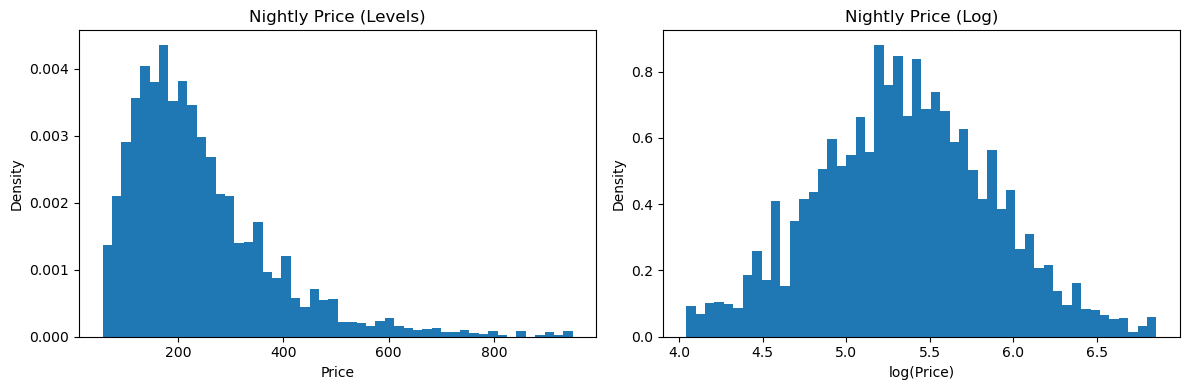

In [12]:
# Use training data only (Amsterdam Q1)
prices = ams_q1_f["price_clean"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) Price in levels
axes[0].hist(prices, bins=50, density=True)
axes[0].set_title("Nightly Price (Levels)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Density")

# (b) Price in logs
axes[1].hist(np.log(prices), bins=50, density=True)
axes[1].set_title("Nightly Price (Log)")
axes[1].set_xlabel("log(Price)")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()


The distribution of nightly prices is highly right-skewed in levels, while the log transformation yields a more symmetric and well-behaved distribution, motivating the use of log price as the modeling target.

---

## Modeling: OLS & LASSO 

#### 1. Preparing Traget and features

In [13]:
# ---- Feature columns definition ----

BASE_NUMERIC = [
    "accommodates", "bedrooms", "beds", "minimum_nights", "availability_365",
    "number_of_reviews", "reviews_per_month",
    "host_listings_count", "host_total_listings_count",
    "n_amenities"
]

CATEGORICAL = ["room_type"]

def pick_existing(df, cols):
    return [c for c in cols if c in df.columns]

num_cols = pick_existing(ams_q1_fe, BASE_NUMERIC)
cat_cols = pick_existing(ams_q1_fe, CATEGORICAL)

amen_cols = [c for c in ams_q1_fe.columns if c.startswith("amen_")]

feature_cols = num_cols + cat_cols + amen_cols

print("Numeric:", len(num_cols))
print("Categorical:", len(cat_cols))
print("Amenities:", len(amen_cols))
print("Total features:", len(feature_cols))


# Target: log price
TARGET = "price_clean"

train_df = ams_q1_fe.copy()

y = np.log(train_df[TARGET])
X = train_df[feature_cols]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Numeric: 10
Categorical: 1
Amenities: 50
Total features: 61
Train: (4635, 61) Test: (1159, 61)


#### 2. Preprocessing pipeline

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_features = num_cols + amen_cols
categorical_features = cat_cols

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ],
    remainder="drop"
)


### Model 1. OLS (Linear Regression)

In [15]:
import time

ols = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

t0 = time.time()
ols.fit(X_train, y_train)
ols_time = time.time() - t0

ols_pred = ols.predict(X_test)
ols_rmse = np.sqrt(mean_squared_error(y_test, ols_pred))
ols_r2 = r2_score(y_test, ols_pred)

print(f"OLS → RMSE (log): {ols_rmse:.3f} | R²: {ols_r2:.3f} | time: {ols_time:.2f}s")


OLS → RMSE (log): 0.377 | R²: 0.486 | time: 0.12s


### Model 2. LASSO (with Cross-Validation)

In [16]:
from sklearn.linear_model import LassoCV

lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LassoCV(
        alphas=np.logspace(-4, 1, 30),
        cv=5,
        max_iter=10000,
        random_state=42
    ))
])

t0 = time.time()
lasso.fit(X_train, y_train)
lasso_time = time.time() - t0

lasso_pred = lasso.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"LASSO → RMSE (log): {lasso_rmse:.3f} | R²: {lasso_r2:.3f} | time: {lasso_time:.2f}s")
print("Chosen alpha:", lasso.named_steps["model"].alpha_)


LASSO → RMSE (log): 0.377 | R²: 0.487 | time: 0.68s
Chosen alpha: 0.0001


### - Starting the Horserace table

In [17]:
horserace = pd.DataFrame([
    {"Model": "OLS", "RMSE_log": ols_rmse, "R2": ols_r2, "Time_s": ols_time},
    {"Model": "LASSO", "RMSE_log": lasso_rmse, "R2": lasso_r2, "Time_s": lasso_time},
])

horserace

,Model,RMSE_log,R2,Time_s
0,OLS,0.376846,0.485975,0.121017
1,LASSO,0.376600,0.486646,0.681810


Most features are informative; shrinkage does not dramatically improve performance over OLS.
OLS and LASSO perform similarly in terms of predictive accuracy. The LASSO penalty does not lead to substantial gains, suggesting that multicollinearity or overfitting is not severe at this stage, or that most features contribute useful signal.

### Model 3. Random Forest model block

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300, #stable forest
        max_depth=None,
        min_samples_leaf=5, #reduces overfitting
        n_jobs=-1, #use all cores
        random_state=42 #reproducibility
    ))
])

t0 = time.time()
rf.fit(X_train, y_train)
rf_time = time.time() - t0

rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"RF → RMSE (log): {rf_rmse:.3f} | R²: {rf_r2:.3f} | time: {rf_time:.2f}s")


RF → RMSE (log): 0.353 | R²: 0.548 | time: 1.82s


In [19]:
### Appending RF to the horserace
horserace = pd.concat([
    horserace,
    pd.DataFrame([{
        "Model": "Random Forest",
        "RMSE_log": rf_rmse,
        "R2": rf_r2,
        "Time_s": rf_time
    }])
], ignore_index=True)

horserace

,Model,RMSE_log,R2,Time_s
0,OLS,0.376846,0.485975,0.121017
1,LASSO,0.376600,0.486646,0.681810
2,Random Forest,0.353401,0.547945,1.823399


**Random Forest substantially outperforms linear models**, indicating the presence of nonlinearities and interaction effects between listing characteristics, amenities, and room type that are not captured by linear specifications.


### Model 4. Boosting (Gradient Boosting Regressor)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(
        n_estimators=300, #smooth learning
        learning_rate=0.05,
        max_depth=3, #shallow trees (avoid overfitting)
        subsample=0.8, #regularization via stochastic boosting
        random_state=42
    ))
])

t0 = time.time()
gbr.fit(X_train, y_train)
gbr_time = time.time() - t0

gbr_pred = gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))
gbr_r2 = r2_score(y_test, gbr_pred)

print(f"Boosting → RMSE (log): {gbr_rmse:.3f} | R²: {gbr_r2:.3f} | time: {gbr_time:.2f}s")

Boosting → RMSE (log): 0.352 | R²: 0.552 | time: 3.35s


In [21]:
# Appending GBM to the horserace
horserace = pd.concat([
    horserace,
    pd.DataFrame([{
        "Model": "Gradient Boosting",
        "RMSE_log": gbr_rmse,
        "R2": gbr_r2,
        "Time_s": gbr_time
    }])
], ignore_index=True)

horserace

,Model,RMSE_log,R2,Time_s
0,OLS,0.376846,0.485975,0.121017
1,LASSO,0.376600,0.486646,0.681810
2,Random Forest,0.353401,0.547945,1.823399
3,Gradient Boosting,0.352004,0.551512,3.348488


### Model 5. Extra Trees model 

In [22]:
from sklearn.ensemble import ExtraTreesRegressor

etr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ExtraTreesRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ))
])

t0 = time.time()
etr.fit(X_train, y_train)
etr_time = time.time() - t0

etr_pred = etr.predict(X_test)
etr_rmse = np.sqrt(mean_squared_error(y_test, etr_pred))
etr_r2 = r2_score(y_test, etr_pred)

print(f"Extra Trees → RMSE (log): {etr_rmse:.3f} | R²: {etr_r2:.3f} | time: {etr_time:.2f}s")


Extra Trees → RMSE (log): 0.355 | R²: 0.545 | time: 1.53s


In [23]:
# Appending Extra Trees to the horserace table
horserace = pd.concat([
    horserace,
    pd.DataFrame([{
        "Model": "Extra Trees",
        "RMSE_log": etr_rmse,
        "R2": etr_r2,
        "Time_s": etr_time
    }])
], ignore_index=True)

horserace


,Model,RMSE_log,R2,Time_s
0,OLS,0.376846,0.485975,0.121017
1,LASSO,0.376600,0.486646,0.681810
2,Random Forest,0.353401,0.547945,1.823399
3,Gradient Boosting,0.352004,0.551512,3.348488
4,Extra Trees,0.354691,0.544637,1.532257


 Extra Trees introduce additional randomization in split selection compared to Random Forests, which can further reduce variance and improve generalization in high-dimensional feature spaces.


In [24]:
# Final horserace table sorted by RMSE
horserace.sort_values("RMSE_log")

,Model,RMSE_log,R2,Time_s
3,Gradient Boosting,0.352004,0.551512,3.348488
2,Random Forest,0.353401,0.547945,1.823399
4,Extra Trees,0.354691,0.544637,1.532257
1,LASSO,0.376600,0.486646,0.681810
0,OLS,0.376846,0.485975,0.121017


importance

### Part I.4 - Feature Importance (RF & Boosting)

In [25]:
# Because before a pipeline with one-hot encoding was used, we must first reconstruct the feature names the trees actually see.
# get feature names after preprocessing
def get_feature_names(preprocess, num_features, cat_features):
    num_names = num_features
    
    cat_encoder = preprocess.named_transformers_["cat"].named_steps["onehot"]
    cat_names = cat_encoder.get_feature_names_out(cat_features)
    
    return np.concatenate([num_names, cat_names])


In [26]:
# Extracting feature names from Random 
rf_model = rf.named_steps["model"]
rf_preprocess = rf.named_steps["preprocess"]

rf_feature_names = get_feature_names(
    rf_preprocess, numeric_features, categorical_features
)

rf_importance = pd.DataFrame({
    "feature": rf_feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

rf_top10 = rf_importance.head(10)
rf_top10


,feature,importance
1,bedrooms,0.296911
60,room_type_Entire home/apt,0.132000
4,availability_365,0.086401
62,room_type_Private room,0.064625
0,accommodates,0.054390
6,reviews_per_month,0.053540
5,number_of_reviews,0.040752
9,n_amenities,0.032862
3,minimum_nights,0.024538
25,amen_dishwasher,0.016543


In [27]:
# Extract feature importance from Gradient Boosting
gbr_model = gbr.named_steps["model"]
gbr_preprocess = gbr.named_steps["preprocess"]

gbr_feature_names = get_feature_names(
    gbr_preprocess, numeric_features, categorical_features
)

gbr_importance = pd.DataFrame({
    "feature": gbr_feature_names,
    "importance": gbr_model.feature_importances_
}).sort_values("importance", ascending=False)

gbr_top10 = gbr_importance.head(10)
gbr_top10


,feature,importance
1,bedrooms,0.291885
60,room_type_Entire home/apt,0.131133
0,accommodates,0.129772
62,room_type_Private room,0.086384
4,availability_365,0.076440
6,reviews_per_month,0.069086
5,number_of_reviews,0.027995
3,minimum_nights,0.021148
9,n_amenities,0.019290
25,amen_dishwasher,0.018258


In [28]:
# Comparison
comparison = pd.DataFrame({
    "Random Forest": rf_top10["feature"].values,
    "Gradient Boosting": gbr_top10["feature"].values
})

comparison

,Random Forest,Gradient Boosting
0,bedrooms,bedrooms
1,room_type_Entire home/apt,room_type_Entire home/apt
2,availability_365,accommodates
3,room_type_Private room,room_type_Private room
4,accommodates,availability_365
5,reviews_per_month,reviews_per_month
6,number_of_reviews,number_of_reviews
7,n_amenities,minimum_nights
8,minimum_nights,n_amenities
9,amen_dishwasher,amen_dishwasher


Across both Random Forest and Gradient Boosting, nightly price is mainly explained by unit size/capacity and room type, with demand/strategy signals (availability, minimum nights) and review-based popularity playing a secondary role; amenities contribute additional predictive power but do not dominate the pricing signal once the core “space + product type” factors are accounted for.

---

# Part II — Validity and Generalization

In this section, we evaluate whether the models trained on Amsterdam Q1 generalize to:
- **A)** a later snapshot from the same city (Amsterdam Q3), and
- **B)** a different city in the same region (Brussels Q3).

We repeat the same data wrangling and feature engineering steps and then evaluate all five trained models without re-tuning.


### Step 1. Initial data wrangling for both Amsterdam Q3 and Brussels Q3

In [29]:
import re

def clean_price(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(r"[^\d\.]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def parse_amenities(x):
    if pd.isna(x):
        return []
    return re.findall(r'"([^"]+)"', str(x))

def wrangle_listings(df: pd.DataFrame, top_amenities: list, snapshot: str) -> pd.DataFrame:
    df = df.copy()
    df["snapshot"] = snapshot
    
    # 1) price cleaning
    df["price_clean"] = clean_price(df["price"])
    df = df[df["price_clean"].notna() & (df["price_clean"] > 0)]
    
    # 2) outlier filter (same as before: 1–99%)
    p01, p99 = df["price_clean"].quantile([0.01, 0.99])
    df = df[(df["price_clean"] >= p01) & (df["price_clean"] <= p99)]

    # 3) amenities parsing + count
    df["amenities_list"] = df["amenities"].apply(parse_amenities)
    df["n_amenities"] = df["amenities_list"].apply(len)

    # 4) amenity dummy columns using training vocab only
    aset = df["amenities_list"].apply(set)
    for a in top_amenities:
        col = f"amen_{re.sub(r'[^0-9a-zA-Z]+','_', a).lower()}".strip("_")[:60]
        df[col] = aset.apply(lambda s: int(a in s))
        
    return df


In [30]:
ams_q3_wr = wrangle_listings(ams_q3, top_amenities, "amsterdam_q3_2025")
bru_q3_wr = wrangle_listings(bru_q3, top_amenities, "brussels_q3_2025")

print("Rows after wrangling:")
print("Amsterdam Q3:", len(ams_q3_wr))
print("Brussels Q3 :", len(bru_q3_wr))


Rows after wrangling:
Amsterdam Q3: 5760
Brussels Q3 : 4963


For both live datasets, we repeated the same data wrangling and feature engineering pipeline used for training (price parsing, missing value handling, amenity parsing, creation of n_amenities and top-amenity indicators), ensuring identical feature definitions across time and city.

## A. Temporal Validity: Amsterdam Q3

In [31]:
# 1) Collect fitted models (already trained on Amsterdam Q1)
models = {
    "OLS": ols,
    "LASSO": lasso,
    "Random Forest": rf,
    "Gradient Boosting": gbr,
    "Extra Trees": etr
}


In [32]:
#2) Making sure features align across datasets (prevents KeyErrors)

def align_features(df, feature_cols, amen_cols):
    df = df.copy()
    for c in feature_cols:
        if c not in df.columns:
            # For amenity dummies, missing means "doesn't have it"
            if c in amen_cols:
                df[c] = 0
            else:
                # For numeric/categorical, keep as NaN so imputers handle it
                df[c] = np.nan
    return df


In [33]:
# 3) Evaluating any fitted model on a new dataset (log target)
def evaluate_model_on_dataset(model, df, feature_cols, target_col="price_clean"):
    df = df.copy()
    df = df[df[target_col].notna() & (df[target_col] > 0)]
    
    X_new = df[feature_cols]
    y_true = np.log(df[target_col])

    y_pred = model.predict(X_new)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2, len(df)

4) Running validity checks on Amsterdam Q3 and Brussels Q3

In [34]:
# Align datasets to training feature set
ams_q3_eval = align_features(ams_q3_fe, feature_cols, amen_cols)
bru_q3_eval = align_features(bru_q3_fe, feature_cols, amen_cols)

results = []

for name, m in models.items():
    rmse_a, r2_a, n_a = evaluate_model_on_dataset(m, ams_q3_eval, feature_cols)
    rmse_b, r2_b, n_b = evaluate_model_on_dataset(m, bru_q3_eval, feature_cols)

    results.append({"Dataset":"Amsterdam Q3 (later date)", "Model":name, "RMSE_log":rmse_a, "R2":r2_a, "N":n_a})
    results.append({"Dataset":"Brussels Q3 (other city)",  "Model":name, "RMSE_log":rmse_b, "R2":r2_b, "N":n_b})

validity = pd.DataFrame(results)
validity.sort_values(["Dataset","RMSE_log"])
validity

,Dataset,Model,RMSE_log,R2,N
0,Amsterdam Q3 (later date),OLS,0.372528,0.434241,5760
1,Brussels Q3 (other city),OLS,0.851924,-2.052742,4963
2,Amsterdam Q3 (later date),LASSO,0.372108,0.435514,5760
3,Brussels Q3 (other city),LASSO,0.851660,-2.050850,4963
4,Amsterdam Q3 (later date),Random Forest,0.340410,0.527591,5760
5,Brussels Q3 (other city),Random Forest,0.796403,-1.667805,4963
6,Amsterdam Q3 (later date),Gradient Boosting,0.353466,0.490657,5760
7,Brussels Q3 (other city),Gradient Boosting,0.783417,-1.581516,4963
8,Amsterdam Q3 (later date),Extra Trees,0.327016,0.564034,5760
9,Brussels Q3 (other city),Extra Trees,0.820457,-1.831390,4963


5) Comparing against the original holdout horserace

In [35]:
baseline = horserace.copy()
baseline["Dataset"] = "Amsterdam Q1 (holdout test)"
baseline = baseline.rename(columns={"Time_s":"Time_s_fit"})  # keep times separate
baseline = baseline[["Dataset","Model","RMSE_log","R2","Time_s_fit"]]

validity_comp = validity.copy()
validity_comp["Time_s_fit"] = np.nan  # not refitting here
validity_comp = validity_comp[["Dataset","Model","RMSE_log","R2","Time_s_fit"]]

comparison_all = pd.concat([baseline, validity_comp], ignore_index=True)
comparison_all.sort_values(["Dataset","RMSE_log"])


,Dataset,Model,RMSE_log,R2,Time_s_fit
3,Amsterdam Q1 (holdout test),Gradient Boosting,0.352004,0.551512,3.348488
2,Amsterdam Q1 (holdout test),Random Forest,0.353401,0.547945,1.823399
4,Amsterdam Q1 (holdout test),Extra Trees,0.354691,0.544637,1.532257
1,Amsterdam Q1 (holdout test),LASSO,0.376600,0.486646,0.681810
0,Amsterdam Q1 (holdout test),OLS,0.376846,0.485975,0.121017
13,Amsterdam Q3 (later date),Extra Trees,0.327016,0.564034,NaN
9,Amsterdam Q3 (later date),Random Forest,0.340410,0.527591,NaN
11,Amsterdam Q3 (later date),Gradient Boosting,0.353466,0.490657,NaN
7,Amsterdam Q3 (later date),LASSO,0.372108,0.435514,NaN
5,Amsterdam Q3 (later date),OLS,0.372528,0.434241,NaN


### Horserace discussion (fit vs time)

Across all models, tree-based methods outperform linear baselines, indicating nonlinearities and interactions in Airbnb pricing.
- **OLS vs LASSO:** performance is nearly identical, suggesting limited benefit from shrinkage given the chosen feature set.
- **Random Forest / Extra Trees:** large improvement over linear models, capturing nonlinear patterns and interactions.
- **Gradient Boosting:** best overall RMSE and R², consistent with boosting’s ability to sequentially correct residual errors.
In terms of runtime, linear models are fastest, while ensembles (especially boosting) trade more computation for better predictive accuracy.
---

### Validity and Generalization Results

This section evaluates whether the pricing models trained on Amsterdam Q1 generalize across **time** and **geography**. Specifically, we test the trained models on (i) a later snapshot from the same city (Amsterdam Q3) and (ii) a different city within the same region (Brussels Q3), without any re-tuning or re-estimation of model parameters.

####  - Temporal Validity: Amsterdam Q3  
When applied to the later Amsterdam Q3 dataset, all models maintain performance levels comparable to the original holdout test set from Amsterdam Q1. Tree-based models (Random Forest, Gradient Boosting, and Extra Trees) continue to outperform linear models in terms of both RMSE and R², indicating that the nonlinear relationships learned during training remain relevant over time. Although small changes in performance are observed, the overall ranking of models is stable.  

This suggests that the relationship between listing characteristics (such as size, room type, availability, and amenities) and prices is relatively stable over time within the same city. From a business perspective, this implies that a pricing model trained on recent historical data can remain useful for future pricing decisions in the same market, at least over moderate time horizons.

#### - Geographic Validity: Brussels Q3  
In contrast, model performance deteriorates substantially when the Amsterdam-trained models are applied to Brussels Q3. All models exhibit large increases in prediction error and strongly negative R² values, indicating that they perform worse than a naive benchmark that predicts the mean log price for Brussels. This pattern is consistent across linear and tree-based models, suggesting a systematic lack of geographic transferability rather than a failure of a specific algorithm.

The poor performance in Brussels highlights the city-specific nature of Airbnb pricing. Differences in housing stock, regulatory environments, demand patterns, tourism intensity, and the interpretation of amenities likely lead to different pricing mechanisms across cities. As a result, features that are strong price drivers in Amsterdam do not translate directly to Brussels.

#### - Implications  
Taken together, the results indicate strong **temporal validity** but weak **geographic generalization**. While the models generalize well over time within the same city, they do not transfer reliably across cities. This finding underscores the importance of retraining models for each market or incorporating richer location-specific features when scaling pricing models across regions. From a business standpoint, a one-size-fits-all pricing model is unlikely to perform well across different cities without additional adaptation.
